In [ ]:
# !pip install transformers

In [1]:
import os, gc, sys, time, collections, random
import numpy as np
import pandas as pd

from typing import Dict, Optional, Union, Any, List, Tuple

from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn

import torch.utils.data as D
from torch.utils.data.dataset import Dataset, IterableDataset
from torch.utils.data.dataloader import DataLoader

from transformers import DistilBertTokenizerFast
from transformers import DistilBertModel
from transformers import BertTokenizerFast
from transformers import BertModel
from transformers import Trainer
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers.data.processors.utils import InputFeatures
from transformers import TrainingArguments
from transformers.trainer_utils import EvalLoopOutput
from transformers.trainer import logging
from transformers.file_utils import is_torch_tpu_available, is_sagemaker_mp_enabled
from transformers.trainer_pt_utils import find_batch_size, nested_concat, nested_numpify, nested_truncate, nested_detach

### Folders and Dataframes

In [2]:
DATA_PATH = Path('/home/commonlit/data/')
assert DATA_PATH.exists()
MODELS_PATH = Path('/home/commonlit/models/')
if not MODELS_PATH.exists():
    os.mkdir(MODELS_PATH)
assert MODELS_PATH.exists()

In [3]:
!ls {DATA_PATH}

commonlit_lm		       test.csv        train_duo.csv
commonlitreadabilityprize.zip  train-orig.csv
sample_submission.csv	       train.csv


In [4]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')
sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')

In [5]:
train_df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009
...,...,...,...,...,...,...
2844,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2845,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2846,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2847,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [6]:
train_df[train_df['excerpt'].str.contains('Robin Hood')]

,id,url_legal,license,excerpt,target,standard_error
231,21ea485fb,NaN,NaN,A little within the wood there was a fair cast...,-1.302688,0.450399
233,a04741371,NaN,NaN,"The king dwelt for many months in Nottingham, ...",-0.714009,0.506864
234,5cb5ab998,NaN,NaN,"When they drew near Nottingham, all the people...",-1.541347,0.478166
235,622f6215e,NaN,NaN,About this time there was living in Nottingham...,-2.054284,0.538084


In [7]:
train_df[train_df['id'] == '21ea485fb']['excerpt'].values

array(['A little within the wood there was a fair castle, with a double moat, and surrounded by stout walls. Here dwelt that noble knight, Sir Richard Lee, to whom Robin Hood had lent the four hundred pounds to redeem his land.\nHe saw the little company of outlaws fighting their way along, so he hastened to call them to come and take shelter in his castle.\n"Welcome art thou, Robin Hood! Welcome!" he cried, as he led them in. "Much I thank thee for thy comfort and courtesy and great kindness to me in the forest. There is no man in the world I love so much as thee. For all the proud Sheriff of Nottingham, here thou shalt be safe!—Shut the gates, and draw the bridge, and let no man come in!" he shouted to his retainers. "Arm you well; make ready; guard the walls! One thing, Robin, I promise thee: here shalt thou stay for twelve days as my guest, to sup, and eat, and dine."\nSwiftly and readily tables were laid and cloths spread, and Robin Hood and his merry men sat down to a good meal.'

In [8]:
train_df[train_df['id'] == '0bf29d257']['target']

1304   -3.351956
1305   -3.351956
Name: target, dtype: float64

In [9]:
# !pip install seaborn

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target'>

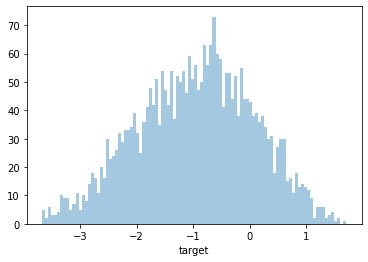

In [11]:
sns.distplot(train_df['target'],bins=100,kde=False)

### Configuration

In [35]:
class CONFIG():
    model_name = 'distilroberta-base'
    batch_size = 48
    max_len = 256
    save_dir = f'trained/{model_name}'
    num_workers = 4
    epochs = 30
    pretrained_transformers_model = 'distilroberta-base'
    num_folds = 6

In [36]:
cfg = CONFIG()

### Prepare Cross Validation

In [37]:
target = train_df['target'].to_numpy()

In [38]:
num_bins = int(np.floor(np.log2(len(train_df))) + 1)
train_df.loc[:, 'bins'] = pd.cut(train_df['target'], bins=num_bins, labels=False)

In [39]:
train_df[['target', 'bins']].groupby(['bins']).agg(['mean', 'count'])

target      
          mean count
bins                
0    -3.411708    44
1    -2.969369    79
2    -2.526589   172
3    -2.106393   269
4    -1.653016   367
5    -1.201392   420
6    -0.748350   485
7    -0.309794   411
8     0.130016   312
9     0.560802   184
10    0.978923    83
11    1.399764    23

In [40]:
kf = StratifiedKFold(n_splits=cfg.num_folds)

In [41]:
for i, (t_, v_) in enumerate(kf.split(X=train_df, y=train_df.bins.values)):
    train_df.loc[v_, 'kfold'] = i

In [42]:
train_df['kfold'] = train_df['kfold'].astype(np.uint8)

In [43]:
train_df = train_df.drop('bins', axis=1)

In [44]:
train_df

,id,url_legal,license,excerpt,target,standard_error,kfold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009,0
...,...,...,...,...,...,...,...
2844,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,5
2845,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,5
2846,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,5
2847,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,5


In [45]:
train_df[['target', 'kfold']].groupby(['kfold']).agg(['mean', 'count'])

target      
           mean count
kfold                
0     -0.957544   475
1     -0.939990   475
2     -0.945112   475
3     -0.979941   475
4     -0.963742   475
5     -0.963504   474

In [46]:
bin_list = list(range(num_bins))
random.shuffle(bin_list)
bin_list

[1, 0, 6, 4, 9, 8, 7, 3, 2, 5, 11, 10]

### Metrics

In [47]:
def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def rmse_score_2(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [48]:
a = np.random.rand(10)
b = np.random.rand(10)

In [49]:
rmse_score(a, b), rmse_score_2(a, b)

(0.3102084563144486, 0.3102084563144486)

### Prepare train test split

In [50]:
def create_split(fold = [1]):
    valid_df = train_df[train_df['kfold'].isin(fold)]
    valid_text = valid_df['excerpt'].values
    valid_target = valid_df['target'].values
    training_df = train_df[~train_df['kfold'].isin(fold)]
    train_text = training_df['excerpt'].values
    train_target = training_df['target'].values
    return train_text, train_target, valid_text, valid_target

In [51]:
train_text, train_target, valid_text, valid_target = create_split([0])
len(train_text), len(valid_text)

(2374, 475)

### Prepare Tokenizers

In [52]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
# Save the tokenizer so that you can download the files and move it to a Kaggle dataset.
tokenizer.save_pretrained(cfg.save_dir)

('trained/distilroberta-base/tokenizer_config.json',
 'trained/distilroberta-base/special_tokens_map.json',
 'trained/distilroberta-base/vocab.json',
 'trained/distilroberta-base/merges.txt',
 'trained/distilroberta-base/added_tokens.json',
 'trained/distilroberta-base/tokenizer.json')

In [53]:
encoded_dict = tokenizer(train_df['excerpt'].values[0],
                                return_tensors='pt',
                                max_length=cfg.max_len,
                                padding='max_length',
                                truncation=True,
                                return_token_type_ids=True)
decoded = tokenizer.decode(encoded_dict["input_ids"].squeeze())
decoded

'<s>When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes

In [54]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [55]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [56]:
encoded_dict['input_ids'].shape

torch.Size([1, 256])

In [57]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, target, tokenizer, max_len=128):
        self.excerpt = text
        self.target = target
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self, idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return InputFeatures(input_ids=convert_to_list(encode['input_ids']),
                      attention_mask=convert_to_list(encode['attention_mask']),
                      label=torch.tensor(self.target[idx]))
    
    def __len__(self):
        return len(self.excerpt)

In [58]:
def create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target):
    train_ds = CommonLitDataset(train_text, train_target, tokenizer, cfg.max_len)
    valid_ds = CommonLitDataset(valid_text, valid_target, tokenizer, cfg.max_len)
    return train_ds, valid_ds

In [59]:
# encode.keys(), target.shape, encode['input_ids'].shape, encode['attention_mask'].shape

In [60]:
# encode['input_ids'][0].squeeze()

### Model

In [61]:
# You can use a Transformer model of your choice.
# transformer_model = DistilBertModel.from_pretrained(cfg.pretrained_transformers_model)
transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [62]:
# transformer_out = transformer_model(input_ids=encode['input_ids'].squeeze(), attention_mask=encode['attention_mask'].squeeze())

In [63]:
# dict(transformer_out)['last_hidden_state'].shape

In [64]:
# torch.mean(transformer_out.last_hidden_state, axis=1).shape

In [65]:
# sample_layer = nn.Linear(768, 1)

In [66]:
model_config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)

In [67]:
model_config

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [68]:
from torch.nn import functional as F

In [69]:
from transformers import PreTrainedModel

class CommonLitModel(PreTrainedModel):
    def __init__(self):
        super(PreTrainedModel, self).__init__()
        self.transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)
        self.drop = nn.Dropout(0.5)
        self.config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)
        self.layer_norm = nn.LayerNorm(self.config.hidden_size)
        self.out = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.layer_norm)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, input_ids, attention_mask):
        transformer_out = self.transformer_model(input_ids=input_ids.squeeze(), attention_mask=attention_mask.squeeze(), 
                                                 output_hidden_states=False)
        x = transformer_out.pooler_output
#         x = transformer_out.last_hidden_state[:, 0, :] # N, C, X
        x = self.layer_norm(x)
        x = self.drop(x)
        x = self.out(x)
        return x
    
    def floating_point_ops(self, inputs: Dict[str, Union[torch.Tensor, Any]]):
        """
        For models that inherit from :class:`~transformers.PreTrainedModel`, uses that method to compute the number of
        floating point operations for every backward + forward pass. If using another model, either implement such a
        method in the model or subclass and override this method.
        Args:
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.
        Returns:
            :obj:`int`: The number of floating-point operations.
        """
        return 0

In [70]:
model = CommonLitModel()

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [71]:
encoded_dict.token_type_ids

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [72]:
transformer_model = transformer_model.cuda()
sample_out = transformer_model(encoded_dict.input_ids.cuda(), encoded_dict.attention_mask.cuda(), encoded_dict.token_type_ids.cuda(), output_hidden_states=True)

In [73]:
sample_out.pooler_output.shape

torch.Size([1, 768])

In [74]:
sample_out.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [75]:
sample_out['last_hidden_state'].shape, sample_out['last_hidden_state'][:, 0].shape

(torch.Size([1, 256, 768]), torch.Size([1, 768]))

In [76]:
train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)

In [77]:
encode = train_ds[0]

In [78]:
encode.attention_mask.unsqueeze(0).shape, encoded_dict.input_ids.shape

(torch.Size([1, 256]), torch.Size([1, 256]))

In [79]:
sample_out = transformer_model(encode.input_ids.unsqueeze(0).cuda(), encode.attention_mask.unsqueeze(0).cuda())

### Training

In [80]:
import wandb

In [81]:
criterion = nn.MSELoss()

kl_loss = nn.KLDivLoss(reduction = 'batchmean')

def loss_fct(yhat, y):
    return criterion(yhat, y) * 0.7 + 0.3 * kl_loss(yhat, y)

loss_fct = nn.MSELoss()

def loss_fct(yhat, y):
    return torch.sqrt(criterion(yhat, y))

In [82]:
def create_training_args(fold):
    training_args = TrainingArguments(
        output_dir=str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{fold}"),
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=cfg.batch_size,
        per_device_eval_batch_size=cfg.batch_size,
        num_train_epochs=cfg.epochs,
        logging_strategy="epoch",
        logging_first_step=True,
        save_steps=40000,
        fp16=True,
        evaluation_strategy="epoch",
        save_total_limit = 3,
        load_best_model_at_end=True,
        metric_for_best_model='mse',
        greater_is_better=False,
        gradient_accumulation_steps=1,
        learning_rate=5e-5
    )
    return training_args

In [83]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {'mse': mean_squared_error(logits, labels), 'rmse': rmse_score_2(logits, labels)}

In [84]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)

In [85]:
logger = logging.get_logger(__name__)

class CommonLitTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        input_ids = inputs.pop("input_ids")
        attention_mask = inputs.pop("attention_mask")
        outputs = model(input_ids, attention_mask)
        logits = outputs
        loss = loss_fct(logits.flatten(),
                        labels.float().flatten())
        zero_cat = torch.zeros([1, 1]).to(outputs.device)
        return (loss, torch.cat([zero_cat, outputs])) if return_outputs else loss

In [86]:
!rm -rf /home/commonlit/models/{cfg.model_name.replace('/', '_')}-*

In [87]:
%%time

from transformers import EarlyStoppingCallback

bin_step = 1
bestmodels = []
eval_rmses = []
for i in range(0, cfg.num_folds, bin_step):
    train_bins = bin_list[i:i+bin_step]
    print('train_bins', f'{i}: {train_bins}')
    tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
    train_text, train_target, valid_text, valid_target = create_split([i])
    train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)
    training_args = create_training_args(i)
    model = CommonLitModel()
    wandb.init(project=f"commonlit_{cfg.model_name.replace('/', '_')}")
    trainer = CommonLitTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=12)]
    )
    trainer.train()
    trainer.save_model()
    print('training_args.output_dir', training_args.output_dir)
    tokenizer.save_pretrained(training_args.output_dir)
    result = trainer.evaluate()
    bestmodels.append(trainer.state.best_model_checkpoint)
    print('best_model_checkpoint', trainer.state.best_model_checkpoint)
    print('result', result)
    eval_rmses.append(result['eval_rmse'])

train_bins 0: [1]


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
wandb: Currently logged in as: gilf (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.048100,0.711878,0.539422,0.734453
2,0.695500,0.954314,0.929506,0.964109
3,0.657500,0.678899,0.476676,0.690418
4,0.615400,0.668553,0.464281,0.681382
5,0.492200,0.677725,0.469504,0.685204
6,0.449400,0.623263,0.402743,0.634620
7,0.401400,0.617413,0.388365,0.623190
8,0.375800,0.607890,0.389070,0.623755
9,0.386200,0.628184,0.406874,0.637867
10,0.326200,0.602406,0.373853,0.611435


training_args.output_dir /home/commonlit/models/distilroberta-base-0


best_model_checkpoint /home/commonlit/models/distilroberta-base-0/checkpoint-500
result {'eval_loss': 0.6024057269096375, 'eval_mse': 0.37385284900665283, 'eval_rmse': 0.611435055732727, 'eval_runtime': 1.6008, 'eval_samples_per_second': 296.729, 'epoch': 22.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 566582272}
train_bins 1: [0]


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.2166
train/learning_rate,1e-05
train/epoch,22.0
train/global_step,1100
_runtime,358
_timestamp,1623697098
_step,46
eval/loss,0.60241
eval/mse,0.37385
eval/rmse,0.61144
eval/runtime,1.6008


train/loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval/loss,▃█▃▂▂▁▁▁▂▁▃▁▄▂▅▂▄▂▂▂▂▃▁
eval/mse,▃█▂▂▂▁▁▁▁▁▃▁▄▂▄▂▃▁▂▂▂▂▁
eval/rmse,▃█▃▂▂▁▁▁▂▁▃▁▄▂▅▂▄▂▂▂▂▂▁
eval/runtime,▁▃▃▃▄█▄▅▅▅▄▆▂▅▁▅▅▇▅▅▆▅▇


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.925800,0.642809,0.445888,0.667748
2,0.700100,0.597662,0.358859,0.599049
3,0.598000,0.650914,0.443134,0.665683
4,0.534600,0.556280,0.327197,0.572011
5,0.504100,0.533929,0.291252,0.539678
6,0.434600,0.868538,0.789550,0.888566
7,0.469800,0.630598,0.416119,0.645073
8,0.377900,0.596475,0.371544,0.609544
9,0.345800,0.690463,0.489187,0.699419
10,0.331700,0.670423,0.485224,0.696580


training_args.output_dir /home/commonlit/models/distilroberta-base-1


best_model_checkpoint /home/commonlit/models/distilroberta-base-1/checkpoint-250
result {'eval_loss': 0.5339287519454956, 'eval_mse': 0.2912518382072449, 'eval_rmse': 0.5396775603294373, 'eval_runtime': 1.6272, 'eval_samples_per_second': 291.919, 'epoch': 17.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 566582272}
train_bins 2: [6]


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.255
train/learning_rate,2e-05
train/epoch,17.0
train/global_step,850
_runtime,279
_timestamp,1623697392
_step,36
eval/loss,0.53393
eval/mse,0.29125
eval/rmse,0.53968
eval/runtime,1.6272


train/loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
eval/loss,▃▂▃▁▁█▃▂▄▄▂▃▃▃▃▃▃▁
eval/mse,▃▂▃▂▁█▃▂▄▄▂▃▂▂▃▂▃▁
eval/rmse,▄▂▄▂▁█▃▂▄▄▂▃▃▃▃▃▃▁
eval/runtime,▃▆▁▄▄▃█▃▃▃█▇▇▃▃▃▅▆


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.037000,0.757547,0.619560,0.787121
2,0.757600,0.571396,0.330878,0.575220
3,0.656000,0.905597,0.835323,0.913960
4,0.593200,0.681108,0.488034,0.698594
5,0.553600,0.528632,0.282141,0.531169
6,0.464500,0.556801,0.317770,0.563711
7,0.438200,0.693337,0.491189,0.700849
8,0.391400,0.639943,0.416341,0.645245
9,0.363600,0.617025,0.386547,0.621729
10,0.339900,0.636780,0.411505,0.641486


training_args.output_dir /home/commonlit/models/distilroberta-base-2


best_model_checkpoint /home/commonlit/models/distilroberta-base-2/checkpoint-250
result {'eval_loss': 0.5286315679550171, 'eval_mse': 0.2821405231952667, 'eval_rmse': 0.5311689972877502, 'eval_runtime': 1.6378, 'eval_samples_per_second': 290.021, 'epoch': 17.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 566582272}
train_bins 3: [4]


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.2533
train/learning_rate,2e-05
train/epoch,17.0
train/global_step,850
_runtime,275
_timestamp,1623697680
_step,36
eval/loss,0.52863
eval/mse,0.28214
eval/rmse,0.53117
eval/runtime,1.6378


train/loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
eval/loss,▅▂█▄▁▂▄▃▃▃▃▃▂▄▃▂▁▁
eval/mse,▅▂█▄▁▁▄▃▂▃▃▃▂▃▃▂▁▁
eval/rmse,▆▂█▄▁▂▄▃▃▃▃▃▂▄▃▂▁▁
eval/runtime,▆▄▅▅▅▅▃▁▃▂▂▁▅▅█▇▅▇


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.012500,0.701744,0.510244,0.714314
2,0.733400,0.563441,0.321818,0.567290
3,0.647300,0.471771,0.225728,0.475108
4,0.574600,0.625508,0.401571,0.633696
5,0.518200,0.472535,0.224964,0.474303
6,0.451900,0.624842,0.394132,0.627799
7,0.433900,0.591858,0.352764,0.593940
8,0.373900,0.498427,0.250197,0.500197
9,0.364600,0.553466,0.307471,0.554501
10,0.331100,0.471527,0.224966,0.474306


training_args.output_dir /home/commonlit/models/distilroberta-base-3


best_model_checkpoint /home/commonlit/models/distilroberta-base-3/checkpoint-550
result {'eval_loss': 0.4602508544921875, 'eval_mse': 0.21378952264785767, 'eval_rmse': 0.4623737931251526, 'eval_runtime': 1.6595, 'eval_samples_per_second': 286.227, 'epoch': 23.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 566582272}
train_bins 4: [9]


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.2022
train/learning_rate,1e-05
train/epoch,23.0
train/global_step,1150
_runtime,377
_timestamp,1623698072
_step,48
eval/loss,0.46025
eval/mse,0.21379
eval/rmse,0.46237
eval/runtime,1.6595


train/loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval/loss,█▄▁▆▁▆▅▂▄▁▁▂▃▂▃▃▃▃▂▂▄▃▃▁
eval/mse,█▄▁▅▁▅▄▂▃▁▁▂▃▂▃▃▃▂▂▂▄▂▃▁
eval/rmse,█▄▁▆▁▆▅▂▄▁▁▂▃▂▃▃▃▃▂▂▄▂▃▁
eval/runtime,▁▁▁▁▁▁▁▂▄▁▂▅▁▄▃█▁▂▂▁▆▅▃▃


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.966200,0.861281,0.758226,0.870762
2,0.717200,0.561127,0.321280,0.566816
3,0.597000,0.516013,0.273384,0.522861
4,0.516300,0.643453,0.420403,0.648385
5,0.470900,0.515338,0.270962,0.520540
6,0.428000,0.583463,0.346809,0.588905
7,0.396000,0.522662,0.277687,0.526961
8,0.365700,0.543859,0.304553,0.551863
9,0.365900,0.537397,0.294753,0.542912
10,0.315700,0.627969,0.398335,0.631138


training_args.output_dir /home/commonlit/models/distilroberta-base-4


best_model_checkpoint /home/commonlit/models/distilroberta-base-4/checkpoint-250
result {'eval_loss': 0.5153377056121826, 'eval_mse': 0.2709621787071228, 'eval_rmse': 0.5205402970314026, 'eval_runtime': 1.5947, 'eval_samples_per_second': 297.858, 'epoch': 17.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 566582272}
train_bins 5: [8]


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.2505
train/learning_rate,2e-05
train/epoch,17.0
train/global_step,850
_runtime,279
_timestamp,1623698366
_step,36
eval/loss,0.51534
eval/mse,0.27096
eval/rmse,0.52054
eval/runtime,1.5947


train/loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
eval/loss,█▂▁▄▁▂▁▂▁▃▂▃▂▂▃▄▃▁
eval/mse,█▂▁▃▁▂▁▁▁▃▂▃▂▂▃▃▃▁
eval/rmse,█▂▁▄▁▂▁▂▁▃▂▃▂▂▃▃▃▁
eval/runtime,▂█▂▁▂▂▂▃▂▃▂▂▂▂▂▂▄▂


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,1.006900,0.632562,0.412682,0.642403
2,0.741500,0.803763,0.651737,0.807303
3,0.629800,0.698172,0.490704,0.700503
4,0.521500,0.575579,0.334174,0.578078
5,0.473100,0.633134,0.406100,0.637260
6,0.452800,0.557434,0.312916,0.559389
7,0.388600,0.567293,0.324348,0.569516
8,0.402800,0.561391,0.317895,0.563821
9,0.341100,0.621479,0.389415,0.624031
10,0.337400,0.658229,0.435278,0.659756


training_args.output_dir /home/commonlit/models/distilroberta-base-5


best_model_checkpoint /home/commonlit/models/distilroberta-base-5/checkpoint-300
result {'eval_loss': 0.5574339628219604, 'eval_mse': 0.3129163384437561, 'eval_rmse': 0.5593892335891724, 'eval_runtime': 1.6024, 'eval_samples_per_second': 295.801, 'epoch': 18.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 566582272}
CPU times: user 41min 53s, sys: 11min 19s, total: 53min 13s
Wall time: 32min 31s


In [91]:
BEST_MODEL_FOLDER = MODELS_PATH/cfg.model_name/'best'
!rm -rf {BEST_MODEL_FOLDER}
!mkdir -p {BEST_MODEL_FOLDER}

In [92]:
'Mean best RSME losses', np.array(eval_rmses).mean()

('Mean best RSME losses', 0.5374308228492737)

In [90]:
bestmodels[0], MODELS_PATH

('/home/commonlit/models/distilroberta-base-0/checkpoint-500',
 PosixPath('/home/commonlit/models'))

In [ ]:
(MODELS_PATH/'roberta-large-0/checkpoint-1853').exists(),
(MODELS_PATH/'roberta-large-1/checkpoint-1526').exists(),
(MODELS_PATH/'roberta-large-2/checkpoint-2616').exists()

In [ ]:
bestmodels = [MODELS_PATH/'roberta-large-0/checkpoint-1853',
              MODELS_PATH/'roberta-large-1/checkpoint-1526',
              MODELS_PATH/'roberta-large-2/checkpoint-2616',
              MODELS_PATH/'roberta-large-3/checkpoint-1417',
              MODELS_PATH/'roberta-large-4/checkpoint-1417',
              MODELS_PATH/'roberta-large-5/checkpoint-1635',
              MODELS_PATH/'roberta-large-6/checkpoint-1526',
              MODELS_PATH/'roberta-large-7/checkpoint-1635',
              MODELS_PATH/'roberta-large-8/checkpoint-1526',
              MODELS_PATH/'roberta-large-9/checkpoint-2071',
              MODELS_PATH/'roberta-large-10/checkpoint-1417',
              MODELS_PATH/'roberta-large-11/checkpoint-1308']

In [ ]:
BEST_MODEL_FOLDER

In [ ]:
from shutil import copyfile

def normalize_name(path_name):
    return path_name.replace('', '')

for i, best_model in enumerate(bestmodels):
    print(f'Processing {i}th model')
    best_model_file = f'{best_model}/pytorch_model.bin'
    if Path(best_model_file).exists():
        copyfile(best_model_file, f'{BEST_MODEL_FOLDER}/{i}_pytorch_model.bin')
        tokenizer_path = Path(BEST_MODEL_FOLDER/f'tokenizer-{i}')
        tokenizer_path.mkdir(parents=True, exist_ok=True)
        assert tokenizer_path.exists()

        tokenizer_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/tokenizer.json'))
        assert tokenizer_json.exists(), f'{tokenizer_json} does not exist'
        copyfile(tokenizer_json, tokenizer_path/'tokenizer.json')

#         vocab_txt = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/vocab.json'))
#         assert vocab_txt.exists(), f'{vocab_txt} does not exist'
#         copyfile(vocab_txt, tokenizer_path/'vocab.json')

        config_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/config.json'))
        assert config_json.exists()
        copyfile(config_json, tokenizer_path/'config.json')
    else:
        print(f'{best_model_file} is missing')

In [ ]:
import shutil

shutil.make_archive(MODELS_PATH/cfg.model_name/'best_models', 'zip', BEST_MODEL_FOLDER)

In [ ]:
!ls {MODELS_PATH/cfg.model_name}

In [ ]:
!du -h {MODELS_PATH/cfg.model_name}/*

In [ ]:
!kaggle datasets init -p {MODELS_PATH/cfg.model_name}

In [ ]:
dataset_json_path = Path(MODELS_PATH/cfg.model_name/'dataset-metadata.json')
assert dataset_json_path.exists()

In [ ]:
!cat {str(dataset_json_path)}

In [ ]:
with open(dataset_json_path, 'r') as f:
    dataset_json = f.read()
    dataset_json = dataset_json.replace('INSERT_TITLE_HERE', f'commonlit-{cfg.model_name}').replace('INSERT_SLUG_HERE', f'commonlit-{cfg.model_name}')
    print(dataset_json)
with(open(dataset_json_path, 'w')) as f:
    f.write(dataset_json)

In [ ]:
!rm -rf {MODELS_PATH/cfg.model_name}/best

In [ ]:
shutil.make_archive(MODELS_PATH/cfg.model_name/'best_lm_model', 'zip', MODELS_PATH/f'{cfg.model_name}_lm/best_lm')

In [ ]:
!kaggle datasets create -p {MODELS_PATH/cfg.model_name}

In [ ]:
state_dict = torch.load(str(MODELS_PATH/f'distilroberta-0/checkpoint-105/pytorch_model.bin'))

In [ ]:
loaded_model = CommonLitModel()

In [ ]:
loaded_model.load_state_dict(state_dict)